In [1]:
import numpy as np
import pickle
from tqdm import *
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.utils.class_weight import compute_sample_weight
from train_predict import train_se,predict_se
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

c:\Users\YM\anaconda3\envs\hao\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
CSI_RSRP_COLUMNS = ['PCell1 -Beam CSI-RSRP','PCell2 -Beam CSI-RSRP','PCell3 -Beam CSI-RSRP',
                    'PCell4 -Beam CSI-RSRP','PCell5 -Beam CSI-RSRP','PCell6 -Beam CSI-RSRP','PCell7 -Beam CSI-RSRP','PCell8 -Beam CSI-RSRP']
CSI_RSRQ_COLUMNS = ['PCell1 -Beam CSI-RSRQ','PCell2 -Beam CSI-RSRQ','PCell3 -Beam CSI-RSRQ',
                    'PCell4 -Beam CSI-RSRQ','PCell5 -Beam CSI-RSRQ','PCell6 -Beam CSI-RSRQ','PCell7 -Beam CSI-RSRQ','PCell8 -Beam CSI-RSRQ']
CSI_SINR_COLUMNS = ['PCell1 -Beam CSI-SINR','PCell2 -Beam CSI-SINR','PCell3 -Beam CSI-SINR',
                    'PCell4 -Beam CSI-SINR','PCell5 -Beam CSI-SINR','PCell6 -Beam CSI-SINR','PCell7 -Beam CSI-SINR','PCell8 -Beam CSI-SINR']
CSI_INDEX_COLUMNS = ['PCell1 -Beam CSI-Index','PCell2 -Beam CSI-Index','PCell3 -Beam CSI-Index',
                    'PCell4 -Beam CSI-Index','PCell5 -Beam CSI-Index','PCell6 -Beam CSI-Index','PCell7 -Beam CSI-Index','PCell8 -Beam CSI-Index']
SS_SINR_COLUMNS = ['SSB Index0 SINR','SSB Index1 SINR','SSB Index2 SINR','SSB Index3 SINR','SSB Index4 SINR','SSB Index5 SINR','SSB Index6 SINR']
SS_RSRP_COLUMNS = ['SSB Index0 RSRP','SSB Index1 RSRP','SSB Index2 RSRP','SSB Index3 RSRP','SSB Index4 RSRP','SSB Index5 RSRP','SSB Index6 RSRP']
CSI_SERVING_COL = ['PCell1 -Beam Serving Beam','PCell2 -Beam Serving Beam','PCell3 -Beam Serving Beam','PCell4 -Beam Serving Beam','PCell5 -Beam Serving Beam',
                   'PCell6 -Beam Serving Beam','PCell7 -Beam Serving Beam','PCell8 -Beam Serving Beam']
CSI_RSRP_IDX_COLUNMS = ['CSI-RSRP-Index0', 'CSI-RSRP-Index1', 'CSI-RSRP-Index2', 'CSI-RSRP-Index3', 'CSI-RSRP-Index4', 'CSI-RSRP-Index5','CSI-RSRP-Index6', 'CSI-RSRP-Index7',
                        'CSI-RSRP-Index8', 'CSI-RSRP-Index9', 'CSI-RSRP-Index10', 'CSI-RSRP-Index11', 'CSI-RSRP-Index12','CSI-RSRP-Index13', 'CSI-RSRP-Index14', 'CSI-RSRP-Index15',
                        'CSI-RSRP-Index16', 'CSI-RSRP-Index17', 'CSI-RSRP-Index18', 'CSI-RSRP-Index19','CSI-RSRP-Index20', 'CSI-RSRP-Index21', 'CSI-RSRP-Index22', 'CSI-RSRP-Index23',
                        'CSI-RSRP-Index24', 'CSI-RSRP-Index25', 'CSI-RSRP-Index26', 'CSI-RSRP-Index27', 'CSI-RSRP-Index28', 'CSI-RSRP-Index29', 'CSI-RSRP-Index30', 'CSI-RSRP-Index31']
CSI_SINR_IDX_COLUNMS = ['CSI-SINR-Index0', 'CSI-SINR-Index1', 'CSI-SINR-Index2', 'CSI-SINR-Index3', 'CSI-SINR-Index4', 'CSI-SINR-Index5','CSI-SINR-Index6', 'CSI-SINR-Index7',
                        'CSI-SINR-Index8', 'CSI-SINR-Index9', 'CSI-SINR-Index10', 'CSI-SINR-Index11', 'CSI-SINR-Index12','CSI-SINR-Index13', 'CSI-SINR-Index14', 'CSI-SINR-Index15',
                        'CSI-SINR-Index16', 'CSI-SINR-Index17', 'CSI-SINR-Index18', 'CSI-SINR-Index19','CSI-SINR-Index20', 'CSI-SINR-Index21', 'CSI-SINR-Index22', 'CSI-SINR-Index23',
                        'CSI-SINR-Index24', 'CSI-SINR-Index25', 'CSI-SINR-Index26', 'CSI-SINR-Index27', 'CSI-SINR-Index28', 'CSI-SINR-Index29', 'CSI-SINR-Index30', 'CSI-SINR-Index31']
PERFORMANCE_COLUMNS = ['NR MAC Throughput DL','NR PRB Num DL/s','NR PRB Num DL/slot','NR RI','NR Avg Rank DL/s',
                       'NR DL Total NACK/s','NR DL Total ACK/s','NR PDSCH Initial BLER','NR PDSCH BLER','NR DL Avg MCS'] 
ALL_COLUMNS = CSI_RSRP_COLUMNS+CSI_RSRQ_COLUMNS+CSI_SINR_COLUMNS+CSI_INDEX_COLUMNS+SS_SINR_COLUMNS+SS_RSRP_COLUMNS+PERFORMANCE_COLUMNS
# 归一化参数
RSRP_MAX = -40
RSRP_MIN = -125
RSRQ_MAX = -4
RSRQ_MIN = -30
SE_MAX = 4000
RI_MAX = 4
MCS_MAX = 27
SINR_MAX = 50
SINR_MIN = -20
RI_COLUMN = ['NR Avg Rank DL/s']
MCS_COLUMN = ['NR DL Avg MCS']
BLER_COLUMN = ['NR PDSCH BLER']
SEVING_IDX = ['Serving idx']
LOC_COLUMNS = ['Longitude','Latitude']
SE_COLUMNS = ['NR MAC Throughput DL','NR PRB Num DL/s']
train_features = LOC_COLUMNS+CSI_RSRP_IDX_COLUNMS+SS_RSRP_COLUMNS

In [ ]:
with open('dataset_514/0415/data_834_linear_by_idx_loc.pkl','rb') as f:
    data_set_834_415 = pickle.load(f)
with open('dataset_514/0418/data_834_linear_by_idx_loc.pkl','rb') as f:
    data_set_834_418 = pickle.load(f)
with open('dataset_514/0420/data_834_linear_by_idx_loc.pkl','rb') as f:
    data_set_834_420 = pickle.load(f)
with open('dataset_514/0426/data_834_linear_by_idx_loc.pkl','rb') as f:
    data_set_834_426 = pickle.load(f)
with open('dataset_514/0412/data_900_linear_by_idx_loc.pkl','rb') as f:
    data_set_900_412 = pickle.load(f)   
    
# with open('dataset_503/data_834_linear_by_idx_415.pkl','rb') as f:
#     data_set_834_415 = pickle.load(f)
# with open('dataset_503/data_900_linear_by_idx_412.pkl','rb') as f:
#     data_set_900_412 = pickle.load(f)
# with open('dataset_503/data_834_linear_by_idx_418.pkl','rb') as f:
#     data_set_834_418 = pickle.load(f)
# with open('dataset_503/data_834_linear_by_idx_420.pkl','rb') as f:
#     data_set_834_420 = pickle.load(f)
# with open('dataset_503/data_834_linear_by_idx_426.pkl','rb') as f:
#     data_set_834_426 = pickle.load(f)
data_set_834 = pd.concat((data_set_834_415,data_set_834_418,data_set_834_420,data_set_834_426))
LANGITUDE = [114,115]
LATITUDE = [22,23]
data_set_834[LOC_COLUMNS[0]] = (data_set_834[LOC_COLUMNS[0]] - LANGITUDE[0])/(LANGITUDE[1]-LANGITUDE[0])
data_set_834[LOC_COLUMNS[1]] = (data_set_834[LOC_COLUMNS[1]] - LATITUDE[0])/(LATITUDE[1]-LATITUDE[0])
data_set_900_412[LOC_COLUMNS[0]] = (data_set_900_412[LOC_COLUMNS[0]] - LANGITUDE[0])/(LANGITUDE[1]-LANGITUDE[0])
data_set_900_412[LOC_COLUMNS[1]] = (data_set_900_412[LOC_COLUMNS[1]] - LATITUDE[0])/(LATITUDE[1]-LATITUDE[0])

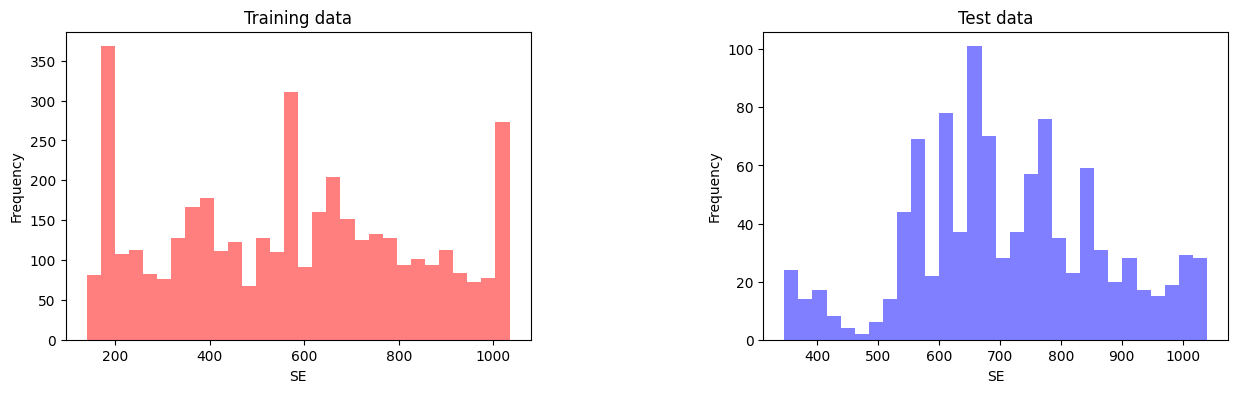

In [20]:
# # with open('dataset_503/data_834_train_test.pkl','rb') as f:
# with open('dataset_503/data_900_train_test.pkl','rb') as f:
#     train,test = pickle.load(f)
    
train,test = train_test_split(data_set_834,test_size=0.2,shuffle=True,random_state=1)
# train,test = train_test_split(data_set_900_412,test_size=0.2,shuffle=False)


train_x = train[train_features]
train_y = train['SE']

test_x = test[train_features]
test_y = test['SE']

# val_x = val[train_features]
# val_y = val['SE']


# 创建三个子图
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一个子图
axs[0].hist(train['NR MAC Throughput DL'], bins=30, alpha=0.5, color='r')
axs[0].set_xlabel('SE')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Training data')

# # # 绘制第二个子图
# # axs[1].hist(val_y, bins=30, alpha=0.5, color='g')
# # axs[1].set_xlabel('SE')
# # axs[1].set_ylabel('Frequency')
# # axs[1].set_title('Validation data')

# 绘制第三个子图
axs[1].hist(test['NR MAC Throughput DL'], bins=30, alpha=0.5, color='b')
axs[1].set_xlabel('SE')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Test data')

# 调整子图之间的距离
plt.subplots_adjust(wspace=0.5)

# 显示图像
plt.show()


train_x = train_x[train_features].to_numpy()
test_x = test_x[train_features].to_numpy()
train_y = train_y.to_numpy()
test_y = test_y.to_numpy()

In [21]:
# 构建模型
svr = SVR(kernel='rbf', C=1, gamma=0.1,epsilon=0.1)
# svr = SVR()
# 训练模型
svr.fit(train_x, train_y)
# 保存模型到文件中
with open('svr_model_900.pkl', 'wb') as f:
# with open('svr_model_834.pkl', 'wb') as f:
    pickle.dump(svr, f)
# 
# 从文件中加载模型
# with open('svr_model_900.pkl', 'rb') as f:
    # svr = pickle.load(f)
svr_y = svr.predict(test_x).flatten()
print("mse :", np.mean((svr_y-test_y)**2))
print("max error:", np.max((svr_y-test_y)**2),)
print("mape:",np.mean(np.abs((svr_y-test_y)/test_y)))
print("sdape:",np.std(np.abs((svr_y-test_y)/test_y)))

mse : 0.005961455820032619
max error: 0.08327324327348398
mape: 0.11671411363506524
sdape: 0.09044560463904273


In [15]:
model_r = xgb.XGBRegressor(max_depth=19,
                               learning_rate=0.1,
                               n_estimators=100,
                               objective='reg:linear', # 此默认参数与 XGBClassifier 不同
                               booster='gbtree',
                               gamma=0,
                               min_child_weight=3,
                               subsample=0.5,
                               colsample_bytree=0.9,
                               reg_alpha=1.2,
                               reg_lambda=1.2,
                               random_state=0)
    
# sample_weight = np.ones(shape=(len(train_y),))
# class_num = 1000
# sample_weight = compute_sample_weight('balanced',np.rint(se_train_y*class_num))
# sample_weight = sample_weight.clip(min=0,max=20)

model_r.fit(train_x,train_y)
# predict_se(model_r,train_x,train_y,SE_MAX,False)
# predict_se(model_r,test_x,test_y,SE_MAX,False)
xgb_y = model_r.predict(test_x).flatten()
print("mse :", np.mean((xgb_y-test_y)**2))
print("max error:", np.max((xgb_y-test_y)**2),)
print("mape:",np.mean(np.abs((xgb_y-test_y)/test_y)))
print("r-square:", 1-np.mean((xgb_y-test_y)**2)/np.var(test_y))

[18:10:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
mse : 0.021867897111392323
max error: 0.1363065779745352
mape: 0.721931979471263
r-square: -4.098545784420601


In [16]:
model_rf = RandomForestRegressor(n_estimators=70,max_depth=15)
model_rf.fit(train_x,train_y)
rf_y = model_rf.predict(test_x).flatten()
print("mse :", np.mean((rf_y-test_y)**2))
print("max error:", np.max((rf_y-test_y)**2),)
print("mape:",np.mean(np.abs((rf_y-test_y)/test_y)))
print("r-square:", 1-np.mean((rf_y-test_y)**2)/np.var(test_y))

mse : 0.014811286154735823
max error: 0.11628929036567555
mape: 0.5853078046748784
r-square: -2.453282233833752


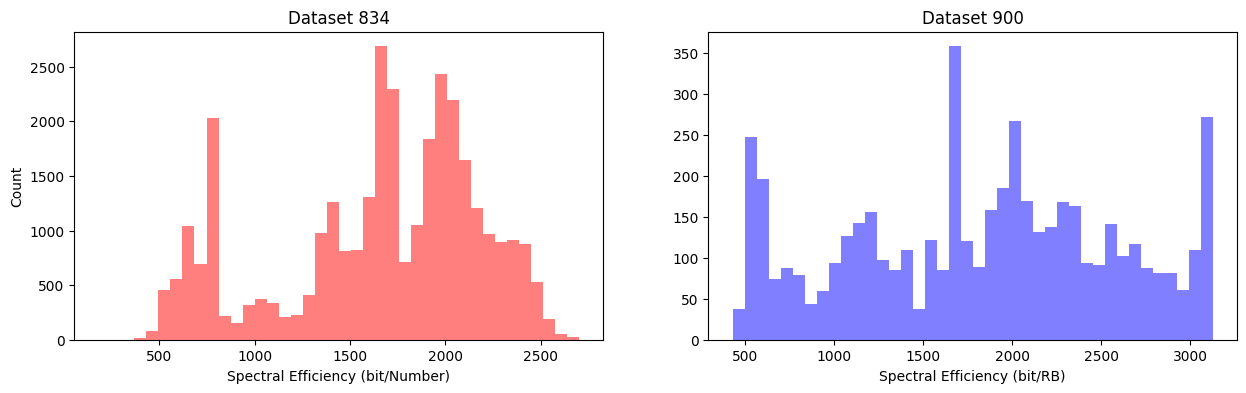

In [7]:

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
bins = 40
# 绘制概率密度函数曲线图
axs[0].hist(data_set_834["SE"]*SE_MAX, bins=bins, alpha=0.5, color='r')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Spectral Efficiency (bit/Number)')
axs[0].set_title('Dataset 834')
# 绘制概率密度函数曲线图
axs[1].hist(data_set_900_412["SE"]*SE_MAX, bins=bins, alpha=0.5, color='b')
axs[1].set_xlabel('Spectral Efficiency (bit/RB)')
axs[1].set_title('Dataset 900')

# 调整子图之间的距离
# plt.subplots_adjust(wspace=0.5)
plt.show()